In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

# Diffusion coefficient
alpha = 0.01

# Define the model: input = [x, t, A, B]
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(4,)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])

In [6]:
def pde_residual(model, x, t, A, B):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        inputs = tf.concat([x, t, A, B], axis=1)
        u = model(inputs)
        u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    u_t = tape.gradient(u, t)
    del tape
    return u_t - alpha * u_xx

In [7]:
def loss_fn(model, x_int, t_int, x_ic, t_bc, A, B):
    # PDE
    f = pde_residual(model, x_int, t_int, A, B)
    loss_pde = tf.reduce_mean(tf.square(f))

    # Initial condition: u(x, 0) = A + (B - A)x
    t0 = tf.zeros_like(x_ic)
    inputs_ic = tf.concat([x_ic, t0, A, B], axis=1)
    u0 = model(inputs_ic)
    u0_true = A + (B - A) * x_ic
    loss_ic = tf.reduce_mean(tf.square(u0 - u0_true))

    # Boundary conditions
    t_rand = t_bc
    x0 = tf.zeros_like(t_rand)
    x1 = tf.ones_like(t_rand)
    u0 = model(tf.concat([x0, t_rand, A, B], axis=1))
    u1 = model(tf.concat([x1, t_rand, A, B], axis=1))
    loss_bc = tf.reduce_mean(tf.square(u0 - A)) + tf.reduce_mean(tf.square(u1 - B))

    return loss_pde + loss_ic + loss_bc



In [8]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

In [9]:
def train_step(x_int, t_int, x_ic, t_bc, A, B):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x_int, t_int, x_ic, t_bc, A, B)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [10]:
N = 1000
x_int = tf.random.uniform((N, 1), 0, 1)
t_int = tf.random.uniform((N, 1), 0, 1)
x_ic = tf.random.uniform((N, 1), 0, 1)
t_bc = tf.random.uniform((N, 1), 0, 1)
A = tf.random.uniform((N, 1), 0, 1)
B = tf.random.uniform((N, 1), 0, 1)

In [12]:
for epoch in range(1001):
    loss = train_step(x_int, t_int, x_ic, t_bc, A, B)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

Epoch 0, Loss: 0.093834
Epoch 100, Loss: 0.084111
Epoch 200, Loss: 0.041766
Epoch 300, Loss: 0.002682
Epoch 400, Loss: 0.001307
Epoch 500, Loss: 0.000938
Epoch 600, Loss: 0.000797
Epoch 700, Loss: 0.000724
Epoch 800, Loss: 0.000669
Epoch 900, Loss: 0.000622
Epoch 1000, Loss: 0.000580


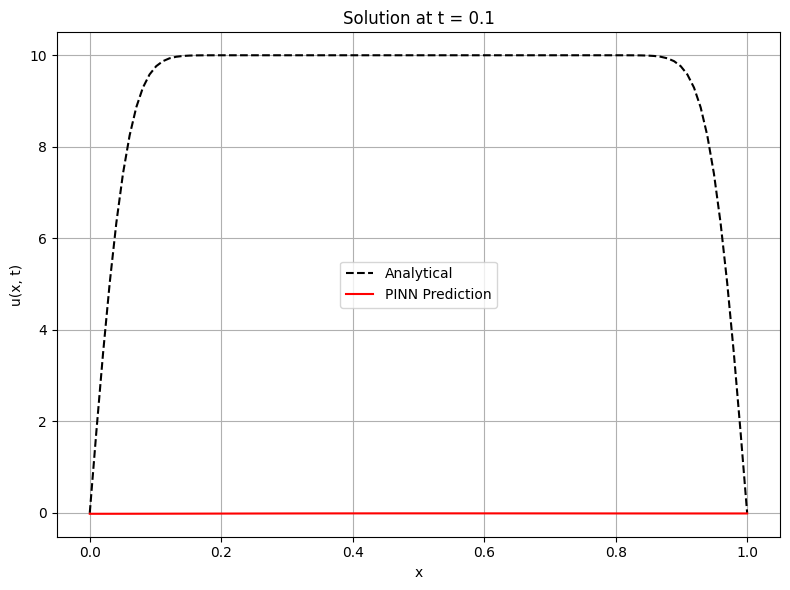

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Parameters
alpha = 0.01
L = 1
t_val = 0.1  # Change this to test at different times

# Define Fourier-based analytical solution
def analytical_solution(x, t, terms=100):
    u = np.zeros_like(x)
    for n in range(1, 2 * terms, 2):  # only odd terms
        A_n = (40 / (n * np.pi))
        u += A_n * np.sin(n * np.pi * x) * np.exp(-alpha * (n * np.pi)**2 * t)
    return u

# Generate test points
x_test = np.linspace(0, L, 100).reshape(-1, 1)
t_test = np.full_like(x_test, t_val)

# Prepare model input (x, t, a, b) — assuming a=0, b=0 for both boundaries
a = np.zeros_like(x_test)
b = np.zeros_like(x_test)
input_tensor = tf.convert_to_tensor(np.hstack([x_test, t_test, a, b]), dtype=tf.float32)

# Predict from the trained model
u_pred = model(input_tensor).numpy().flatten()

# Compute analytical solution
u_analytical = analytical_solution(x_test.flatten(), t_val)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_test, u_analytical, 'k--', label='Analytical')
plt.plot(x_test, u_pred, 'r-', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title(f'Solution at t = {t_val}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
